In [72]:
# !pip install plotly
# !pip install seaborn
# !pip install matplotlib
# !pip install transformers
# !pip install tokenizers
# !pip install scikit-learn
# !pip install tensorflow
# !pip install pandas
# !pip install numpy
# !pip install keras_tuner



In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#
<a id="data-prep"></a>
<div style="background-color: #000D5B; color: white; text-align: center; padding: 6px 0 22px 0">
    <h3 style="background-color: #000D5B; color: white; text-align: left">RMIT School of Computer Science and Technology</h3>
    <br/>
    <h1>COSC3007: Deep Learning</h1>
    <h2>Assignment 2: Stance Twitter Sentiment Analysis and Detection </h2>
    <h2> [2] MODELLING AND MODEL EVALUATIONS </h2>

</div>

# Import Libs

In [74]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import numpy as np

# [1] Load Data

In [75]:
train_df = pd.read_csv("./StanceDataset/processed_train.csv", encoding = "ISO-8859-1", engine="python").drop(columns=['Unnamed: 0'])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_ori = train_df.copy()

test_df = pd.read_csv("./StanceDataset/processed_test.csv", encoding = "ISO-8859-1", engine="python").drop(columns=['Unnamed: 0'])
# Remove rows where the 'target' column is 5
test_df = test_df[test_df['Target'] != 5]

# [2] Prepare label and fit data

## Split test and val

In [76]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

## Tweets

In [77]:
# Load GloVe embeddings
embedding_dim = 100  # This should match the GloVe
glove_dir = 'path_to_glove'
from tqdm import tqdm

embeddings_index = {}
with open("./glove.twitter.27B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [78]:

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_ori['processed_tweet'])

# Convert texts to sequences for all datasets
train_sequences = tokenizer.texts_to_sequences(train_df['processed_tweet'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_tweet'])
val_sequences = tokenizer.texts_to_sequences(val_df['processed_tweet'])

MAX_LENGTH = max(
    max(len(seq) for seq in train_sequences),
    max(len(seq) for seq in val_sequences),
    max(len(seq) for seq in test_sequences)
)

# Pad the sequences
train_pad = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post')
test_pad = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post')
val_pad = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post')

# Extract the word index and vocab size
word_index = tokenizer.word_index
print("Unique tokens: " + str(len(word_index)))
vocab_size = len(word_index) + 1
print('Vocab size: ' + str(vocab_size))

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Unique tokens: 6256
Vocab size: 6257


In [79]:
print(len(train_pad))
print(len(val_df))
print(len(test_pad))

2331
583
1249


## Stances

In [80]:
def categorized_label(df, label_name):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df[label_name])
    categorical_labels = to_categorical(encoded_labels)
    return categorical_labels

In [81]:
train_labels = categorized_label(train_df, "Stance")
test_labels = categorized_label(test_df, "Stance")
val_labels = categorized_label(val_df, "Stance")

# [3] Create Model

In [82]:
from keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import keras_tuner as kt

def f1_score_class(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def f1_score(y_true, y_pred):
    # Convert predictions to one-hot format
    y_pred_one_hot = K.one_hot(K.argmax(y_pred), num_classes=3)

    # Calculate F1 score for each class
    f1s = [f1_score_class(y_true[:, i], y_pred_one_hot[:, i]) for i in range(3)]

    # Average F1 scores across all classes
    return K.mean(K.stack(f1s), axis=0)

Set up call backs and learning rates

In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

# Define the ModelCheckpoint callback
checkpoint_path = "stance_best_model_tuned_weights.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # Only save a model if 'val_loss' has improved
    monitor='val_loss',     # Monitor 'val_loss' during training
    mode='min',             # The model is saved when 'val_loss' is minimized
    verbose=1)

# Combine all callbacks in a list
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint_callback
]


# Combine all callbacks in a list
callbacks1 = [
    early_stopping,
    # lr_scheduler,
    model_checkpoint_callback
]

Set up keras tuner

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import classification_report
import numpy as np
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

    # Tuning the number of units in the first biLSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   dropout=hp.Float('dropout1', min_value=0, max_value=0.8, step=0.1),
                   recurrent_dropout=hp.Float('recurrent_dropout1', min_value=0, max_value=0.5, step=0.1),
                   kernel_regularizer=l2(hp.Float('l2_reg1', min_value=0.0001, max_value=0.01, sampling='LOG')))))

    model.add(Flatten())

    # Dense layer with tunable units
    model.add(Dense(
        units=hp.Int('dense_layer_units_1', min_value=32, max_value=512, step=32),
        activation="relu",
        kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=0.0001, max_value=0.005, sampling='LOG'))
    ))

    # Tunable dropout rate for the second layer
    dropout_rate_3 = hp.Float('dropout__layer_3', min_value=0.0, max_value=0.8, step=0.1)
    model.add(Dropout(dropout_rate_3))

    # Final Layer
    model.add(Dense(3, activation='softmax'))

    # Tuning the learning rate for the optimizer
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', f1_score])

    return model


KERAS TUNER WILL FIND THE BEST HPS then further tune the model with the best hps

In [86]:
best_model = None
best_hps = None

# Hyperparameter tuning configuration
objective = kt.Objective("val_f1_score", direction="max")
tuning_config = {
    'objective': objective,
    'max_epochs': 30,
    'directory': 'keras_tuner_dir',
    'project_name': 'lstm_stance_classification_2nd'
}

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

batch_size = 32

# for batch_size in batch_sizes:
print(f"Trying batch size: {batch_size}")

# Initialize the tuner
tuner = kt.Hyperband(build_model, **tuning_config)

# Search for the best hyperparameters
tuner.search(train_pad, train_labels,
            epochs=50,
            validation_data=(val_pad, val_labels),
            callbacks=[stop_early],
            batch_size=batch_size)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model.save('stance_best_model_model.h5')
best_model.save_weights("stance_best_model_weights.h5")

Trial 90 Complete [00h 01m 19s]
val_f1_score: 0.5576887130737305

Best val_f1_score So Far: 0.5820213556289673
Total elapsed time: 00h 52m 41s


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
results = best_model.evaluate(test_pad, test_labels)
print('Test accuracy:', results)

40/40 [==============================] - 1s 13ms/step - loss: 1.0238 - categorical_accuracy: 0.6325 - f1_score: 0.4458
Test accuracy: [1.0238492488861084, 0.6325060129165649, 0.44581443071365356]


In [88]:
# Get model predictions
predictions = best_model.predict(test_pad)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, convert them to class labels
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

40/40 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       715
           1       0.55      0.47      0.51       304
           2       0.44      0.48      0.46       230

    accuracy                           0.63      1249
   macro avg       0.57      0.57      0.57      1249
weighted avg       0.63      0.63      0.63      1249



In [89]:
with open('./glove_lstm_best_hyperparameters.txt', 'w') as f:
    for hparam in best_hps.values:
        f.write(f"{hparam}: {best_hps.get(hparam)}\n")

Recreate the best model with more training time

In [90]:
def load_hyperparameters(file_path):
    hyperparameters = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            # Convert value to the appropriate type
            if value.isdigit():
                value = int(value)  # Convert to integer if possible
            elif value.replace('.', '', 1).isdigit() and '.' in value:
                value = float(value)  # Convert to float if possible
            hyperparameters[key] = value
    return hyperparameters

# Load the hyperparameters
file_path = './glove_lstm_best_hyperparameters.txt'  # Replace with your file path
best_hps = load_hyperparameters(file_path)

In [91]:
best_hps

{'units1': 32,
 'dropout1': 0.30000000000000004,
 'recurrent_dropout1': 0.30000000000000004,
 'l2_reg1': 0.0004055150366826125,
 'dense_layer_units_1': 224,
 'dense_l2_reg': 0.0016589526278703375,
 'dropout__layer_3': 0.8,
 'learning_rate': 0.0016844246459205988,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': 65}

In [92]:
def build_model_from_dict(hp_dict):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

    # Use the hyperparameter values from the dictionary
    model.add(Bidirectional(LSTM(units=hp_dict['units1'],
                   return_sequences=True,
                   dropout=hp_dict['dropout1'],
                   recurrent_dropout=hp_dict['recurrent_dropout1'],
                   kernel_regularizer=l2(hp_dict['l2_reg1']))))

    model.add(Flatten())

    # Dense layer with tunable units
    model.add(Dense(
        units=hp_dict['dense_layer_units_1'],
        activation="relu",
        kernel_regularizer=l2(hp_dict['dense_l2_reg'])
    ))

    # Tunable dropout rate for the second layer
    dropout_rate_3 = hp_dict['dropout__layer_3']
    model.add(Dropout(dropout_rate_3))

    # Final Layer
    model.add(Dense(3, activation='softmax'))

    # Tuning the learning rate for the optimizer
    model.compile(optimizer=Adam(hp_dict['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', f1_score])

    return model

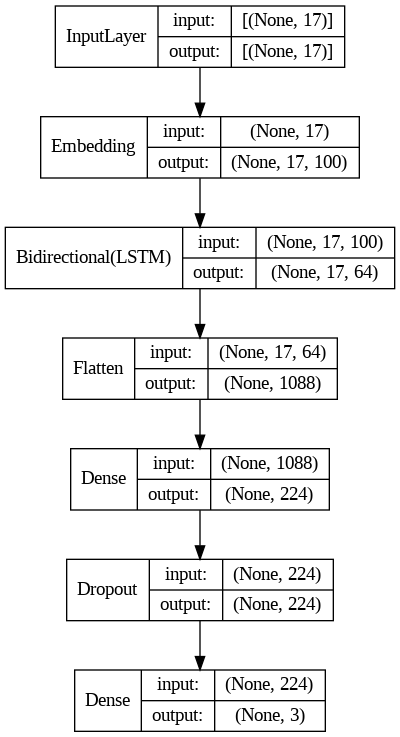

In [93]:
from tensorflow.keras.utils import plot_model
model = build_model_from_dict(best_hps)
plot_model(model, show_layer_names=False, show_shapes=True, to_file='tuned_stance_model.png')

In [94]:
history = {}
history['tuned_stance_model'] = model.fit(train_pad, train_labels,
                    epochs=100,
                    validation_data=(val_pad, val_labels),
                    batch_size=32,
                    callbacks=callbacks1,
                    shuffle = True)

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 1.5608 - categorical_accuracy: 0.4577 - f1_score: 0.3431
Epoch 1: saving model to stance_best_model_tuned_weights.h5
73/73 [==============================] - 12s 92ms/step - loss: 1.5608 - categorical_accuracy: 0.4577 - f1_score: 0.3431 - val_loss: 1.3543 - val_categorical_accuracy: 0.5180 - val_f1_score: 0.3701
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 1.2971 - categorical_accuracy: 0.5560 - f1_score: 0.4694
Epoch 2: saving model to stance_best_model_tuned_weights.h5
73/73 [==============================] - 6s 80ms/step - loss: 1.2971 - categorical_accuracy: 0.5560 - f1_score: 0.4694 - val_loss: 1.2201 - val_categorical_accuracy: 0.5557 - val_f1_score: 0.4486
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 1.1889 - categorical_accuracy: 0.5719 - f1_score: 0.4905
Epoch 3: saving model to stance_best_model_tuned_weights.h5
73/73 [==============================] - 6s 82ms/

In [95]:
results = model.evaluate(test_pad, test_labels)
print('Test accuracy:', results)

40/40 [==============================] - 1s 13ms/step - loss: 1.0371 - categorical_accuracy: 0.6021 - f1_score: 0.4147
Test accuracy: [1.0370591878890991, 0.6020816564559937, 0.41471409797668457]


In [96]:
from sklearn.metrics import classification_report
import numpy as np
# Get model predictions
predictions = model.predict(test_pad)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, convert them to class labels
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

40/40 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       715
           1       0.51      0.49      0.50       304
           2       0.38      0.40      0.39       230

    accuracy                           0.60      1249
   macro avg       0.53      0.53      0.53      1249
weighted avg       0.60      0.60      0.60      1249



In [97]:
results = model.evaluate(val_pad, val_labels)
print('Test accuracy:', results)

19/19 [==============================] - 0s 13ms/step - loss: 1.0714 - categorical_accuracy: 0.6021 - f1_score: 0.5549
Test accuracy: [1.071435809135437, 0.6020582914352417, 0.5549015402793884]


In [98]:
model.save('stance_best_model_model_extra.h5')
model.save_weights("stance_best_model_weights_extra.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
